In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
price_files = ['ADA-USD.csv', 'AGIX-USD.csv', 'BNB-USD.csv',
               'BTC-USD.csv', 'CAKE-USD.csv', 'DOGE-USD.csv',
               'DOT-USD.csv', 'ETH-USD.csv', 'FET-USD.csv',
               'FIL-USD.csv', 'KCS-USD.csv', 'LINK-USD.csv',
               'LTC-USD.csv', 'OCEAN-USD.csv', 'ROSE-USD.csv', 
               'SOL-USD.csv', 'UNI-USD.csv', 'XMR-USD.csv',
               'XRP-USD.csv', 'XTZ-USD.csv']

## TOKEN MAPPING
trend_to_token_mapping = {
    "bitcoin.csv": "btc",
    "bnb.csv": "bnb",
    "cardano.csv": "ada",
    "chainlink.csv": "link",
    "dogecoin.csv": "doge",
    "ethereum.csv": "eth",
    "fetch.ai.csv": "fet",
    "filecoin.csv": "fil",
    "kucoin.csv": "kcs",
    "litecoin.csv": "ltc",
    "monero.csv": "xmr",
    "oasis network.csv": "rose",
    "ocean protocol.csv": "ocean",
    "pancakeswap.csv": "cake",
    "polkadot.csv": "dot",
    "singularitynet.csv": "agix",
    "solana.csv": "sol",
    "tezos.csv": "xtz",
    "uniswap.csv": "uni",
    "XRP.csv": "xrp"
}

external_data = pd.read_csv('external_data/oecd_unemployment_rates.csv')


tokens = []

for pair in price_files:
    token = pair.split("-")[0].lower()
    tokens.append(token)


In [8]:

crypto_countries =  ['Canada', 'United Kingdom', 'Türkiye',
                     'Japan', 'Mexico', 'United States']

# Filter dataset to include only countries in crypto_countries
unemployment_df = external_data[external_data['Reference area'].isin(crypto_countries)]


In [54]:
# Melt the DataFrame to convert monthly columns to rows
melted_df = pd.melt(unemployment_df, id_vars=['Reference area'], var_name='Month', value_name='Unemployment Rate')

# Pivot the melted DataFrame to convert countries to columns and months to rows
transposed_df = melted_df.pivot(index='Month', columns='Reference area', values='Unemployment Rate')

# Reset the index to convert 'Month' from index to a column
transposed_df.reset_index(inplace=True)

# Remove the name of the columns axis
transposed_df.columns.name = None


In [60]:
# Replace commas with dots in the DataFrame
transposed_df = transposed_df.replace(',', '.', regex=True)

# Convert values of each column to floats
transposed_df[crypto_countries] = transposed_df[crypto_countries].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# Calculate the rolling mean for each column with a window of 12 observations
rolling_mean = transposed_df[crypto_countries] .rolling(window=3, min_periods=1).mean()

# Fill NaN values with the rolling mean
filled_df = transposed_df.fillna(rolling_mean)



,Month,Canada,Japan,Mexico,Türkiye,United Kingdom,United States
0,2019-Apr,5.7,2.4,3.6,13.80,3.90,3.7
1,2019-Aug,5.8,2.3,3.5,14.10,3.90,3.6
2,2019-Dec,5.6,2.2,3.2,13.40,4.00,3.6
3,2019-Feb,5.8,2.4,3.3,13.80,3.90,3.8
4,2019-Jan,5.7,2.5,3.4,13.60,4.00,4.0
...,...,...,...,...,...,...,...
58,2023-Oct,5.7,2.5,2.7,8.60,3.90,3.8
59,2023-Sep,5.6,2.6,2.7,9.10,4.00,3.8
60,2024-Feb,5.8,2.6,2.5,8.70,3.95,3.9
61,2024-Jan,5.7,2.4,2.7,9.00,4.20,3.7


In [62]:
# Convert 'Month' column to datetime
clean_rates_df = filled_df
clean_rates_df['Month'] = pd.to_datetime(transposed_df['Month'])
clean_rates_df.sort_values(by='Month', inplace=True)
clean_rates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 4 to 62
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month           63 non-null     datetime64[ns]
 1   Canada          63 non-null     float64       
 2   Japan           63 non-null     float64       
 3   Mexico          63 non-null     float64       
 4   Türkiye         63 non-null     float64       
 5   United Kingdom  63 non-null     float64       
 6   United States   63 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.9 KB


In [108]:
def get_trend(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'trends/{k}'
            trends_df = pd.read_csv(filename)
            return trends_df
    return f'No Trend for token {token}'

def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'prices/{price_files[idx]}'
    return pd.read_csv(filename)
    
def clean_price_data(price_df):
    #Perform an initial check of df

    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day

    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def clean_trend_data(trend_df):

    
    trend_df['Week'] = pd.to_datetime(trend_df['Week'])
    trend_df['Year'] = pd.to_datetime(trend_df['Week']).dt.year
    trend_df['Month'] = pd.to_datetime(trend_df['Week']).dt.month

    # Convert count to numeric to avoid non-correlation
    trend_df['count'] = pd.to_numeric(trend_df['count'], errors='coerce')
    trend_df['count'] = trend_df['count'].fillna(1)


    return trend_df

def merging_df(price_df, trend_df):
    #Resample data into Weekly data from daily
    weekly_price = price_df.set_index('Date')

    weekly_df = weekly_price.resample('W').agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    weekly_df.reset_index(inplace=True)

    # Set the timeframe for merging
    week0 = trend_df['Week'][0]

    price_trend = weekly_df[weekly_df['Date']>=week0]
    price_trend.reset_index(inplace=True, drop=True)

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='Week')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year_x', 'Month_x', 'count']]
    return price_trend


def correlations(df, token, ax=None):
    correlations = df.corr()
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,12))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax, cmap="mako")
    ax.set_title(f'Correlations for {token}')
    fig.tight_layout()
    return ax

def plot_data(price_df, n_cols, token):

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30, 8))
    fig.tight_layout(pad=5.0)

    axes[0].plot(price_df['Date'], price_df['Close'])
    axes[1].plot(price_df['Date'], np.log(price_df['Volume']))
    axes[0].set(xlabel='Date', ylabel='Price (USD)', title=f'{token}-USD Chart')
    axes[1].set(xlabel='Date', ylabel='log(Volume)', title=f'{token}-USD Volume')

    if n_cols == 3:
        axes[2].plot(price_df['Date'], price_df['count'])
        axes[2].set(xlabel='Date', ylabel='Word Count', title=f"{token}'s Google Trend")



def plot_data_rates(df, token, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,12))         # Sample figsize in inches
    else:
        fig = ax.get_figure()

    ax.plot(df['Date'], np.log(df['Close']), color='red',  label=f'Close Price')
    ax.plot(df['Date'], np.log(df['count']), color='cyan',  label=f'Word Count')
    ax.plot(df['Date'], np.log(df['Canada']), color='purple', label=f"Canda's Unemployment Rate")
    ax.plot(df['Date'], np.log(df['Japan']),  color='orange', label=f"Japan's Unemployment Rate")
    ax.plot(df['Date'], np.log(df['Mexico']), color='green',  label=f"Mexico's Unemployment Rate")
    ax.plot(df['Date'], np.log(df['United States']), color='yellow',   label=f"USA's Unemployment Rate")
    ax.plot(df['Date'], np.log(df['United Kingdom']), color='pink',  label=f"UK's Unemployment Rate")
    ax.plot(df['Date'], np.log(df['Türkiye']), color='blue', label=f"Turkey's Unemployment Rate")

    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Evolution Comparison between Trends on {token}')
    ax.legend(loc='upper left')

    return ax


In [91]:
def add_unemployment_rates(df, crypto_countries):
    monthly_df = df.set_index('Date')

    monthly_df = monthly_df.resample('M').agg({'Close': 'last', 'Volume': 'sum', 'Year_x': 'last', 'Month_x': 'last', 'count': 'sum'})
    monthly_df.reset_index(inplace=True)
    # Set the date to the first day of the month
    monthly_df['Date'] = monthly_df['Date'] + pd.offsets.MonthBegin(-1)

    # Merge the two DataFrames
    merged_df = pd.merge(monthly_df, clean_rates_df, how='left', left_on='Date', right_on='Month')

    # Drop the redundant 'Month' column after merging
    merged_df.drop('Month', axis=1, inplace=True)
    # Calculate the rolling mean for each column with a window of 12 observations
    rolling_mean = merged_df[crypto_countries] .rolling(window=3, min_periods=1).mean()

    # Fill NaN values with the rolling mean
    merged_df = merged_df.fillna(rolling_mean)
    return merged_df

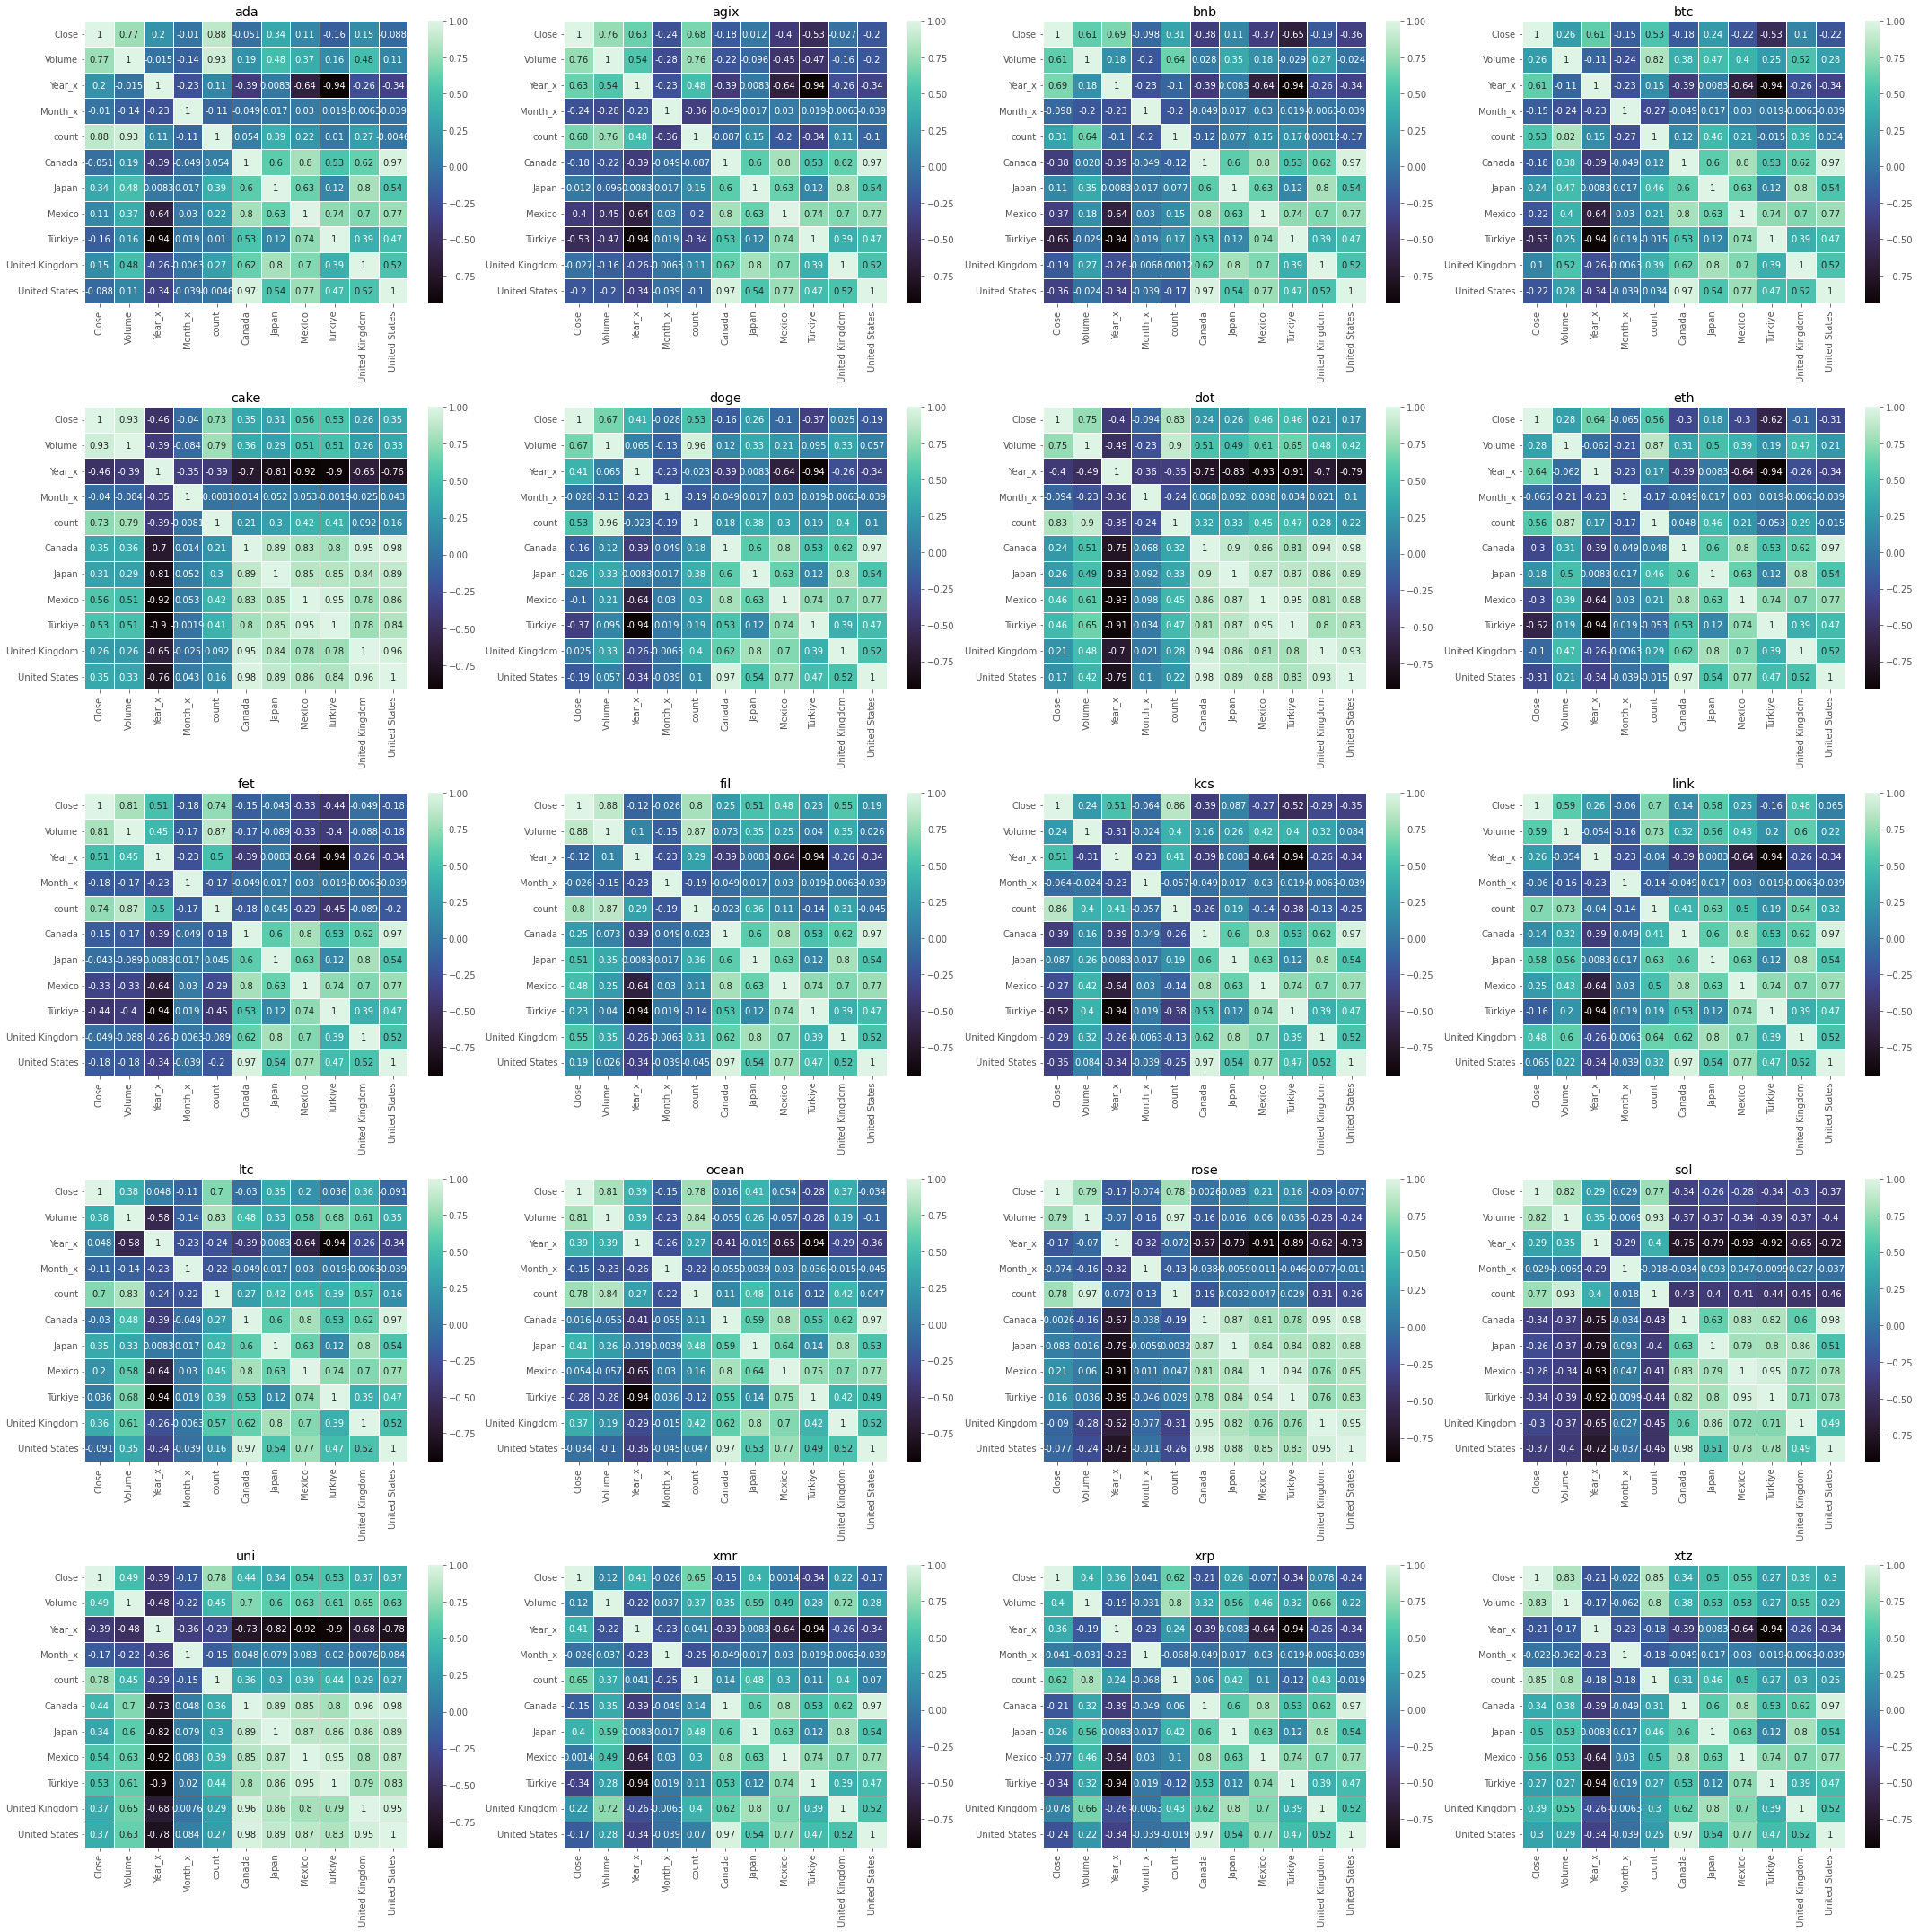

In [94]:
fig, axes = plt.subplots(5, 4, figsize=(30, 30))

for i, token in enumerate(tokens):
    trend_df = get_trend(token, trend_to_token_mapping)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    clean_trend = clean_trend_data(trend_df)
    price_trend_df = merging_df(clean_price, clean_trend)
    final_df = add_unemployment_rates(price_trend_df, crypto_countries)
    ax = axes[i // 4, i % 4]  # Get the appropriate subplot axes
    correlations(final_df, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [114]:
btc_df.columns

Index(['Date', 'Close', 'Volume', 'Year_x', 'Month_x', 'count', 'Canada',
       'Japan', 'Mexico', 'Türkiye', 'United Kingdom', 'United States'],
      dtype='object')

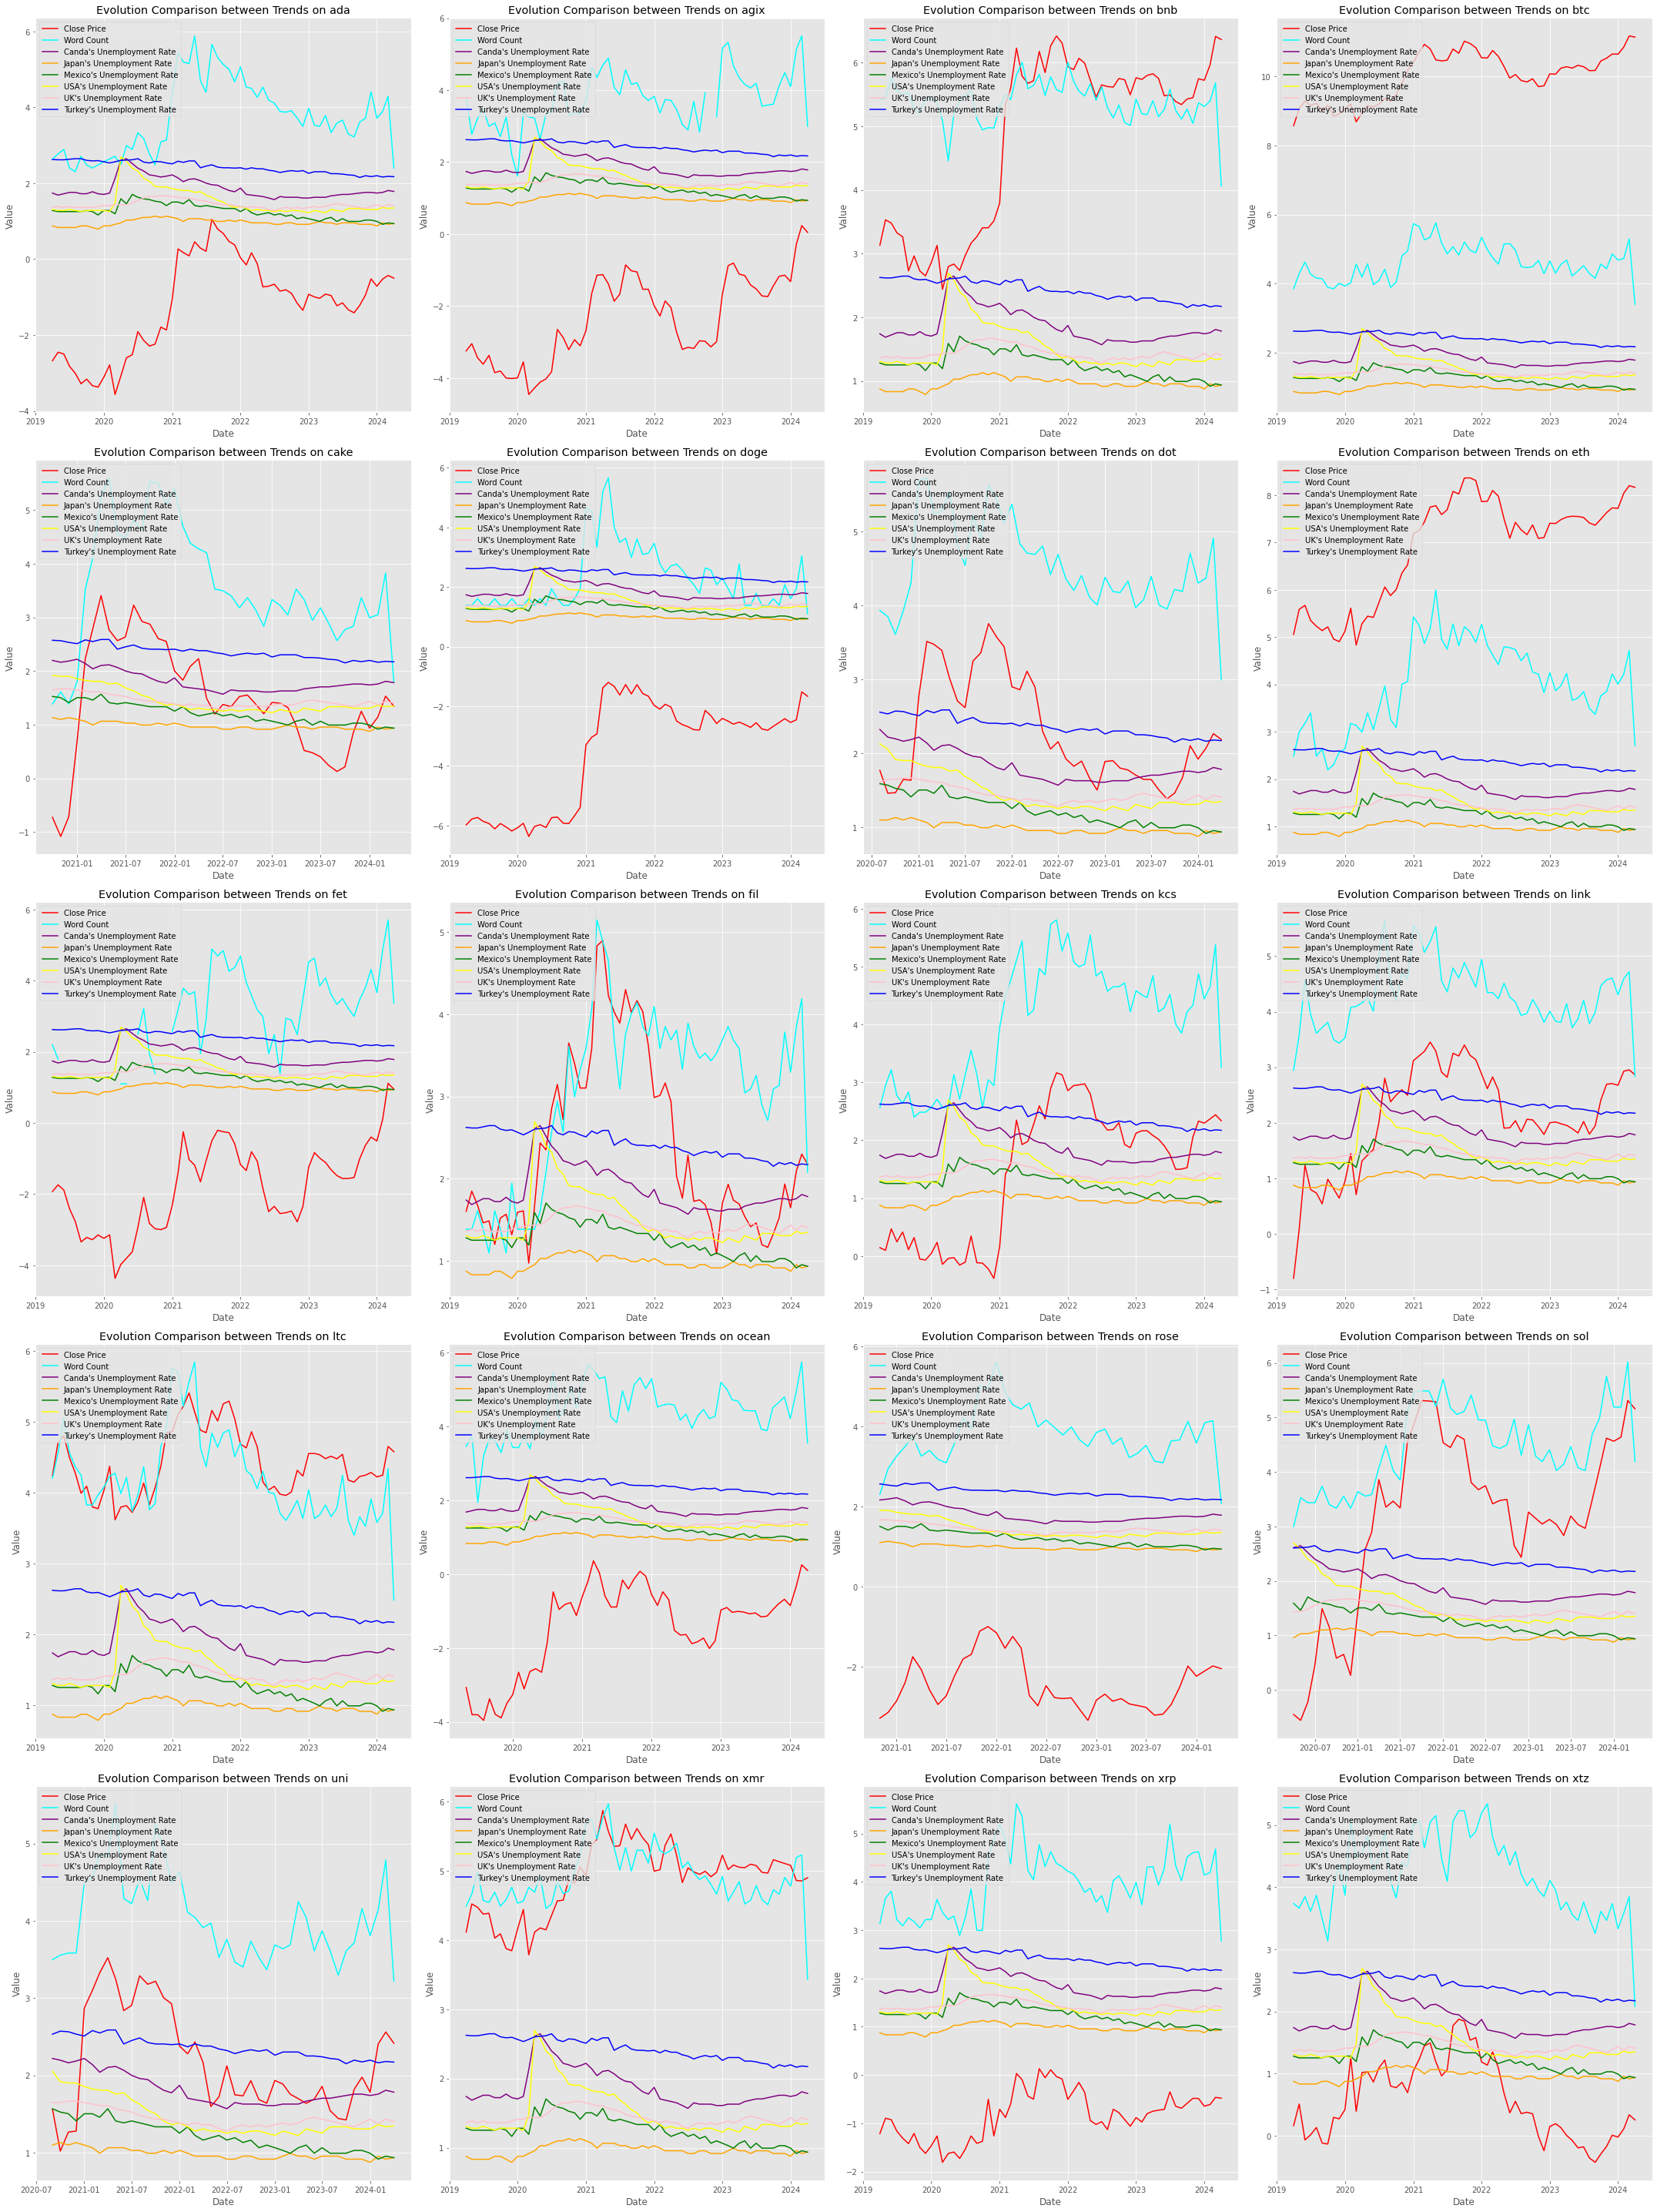

In [117]:
fig, axes = plt.subplots(5, 4, figsize=(30, 40))

for i, token in enumerate(tokens):
    trend_df = get_trend(token, trend_to_token_mapping)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    clean_trend = clean_trend_data(trend_df)
    price_trend_df = merging_df(clean_price, clean_trend)
    final_df = add_unemployment_rates(price_trend_df, crypto_countries)
    ax = axes[i // 4, i % 4]  # Get the appropriate subplot axes
    plot_data_rates(final_df, token, ax=ax)
 
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



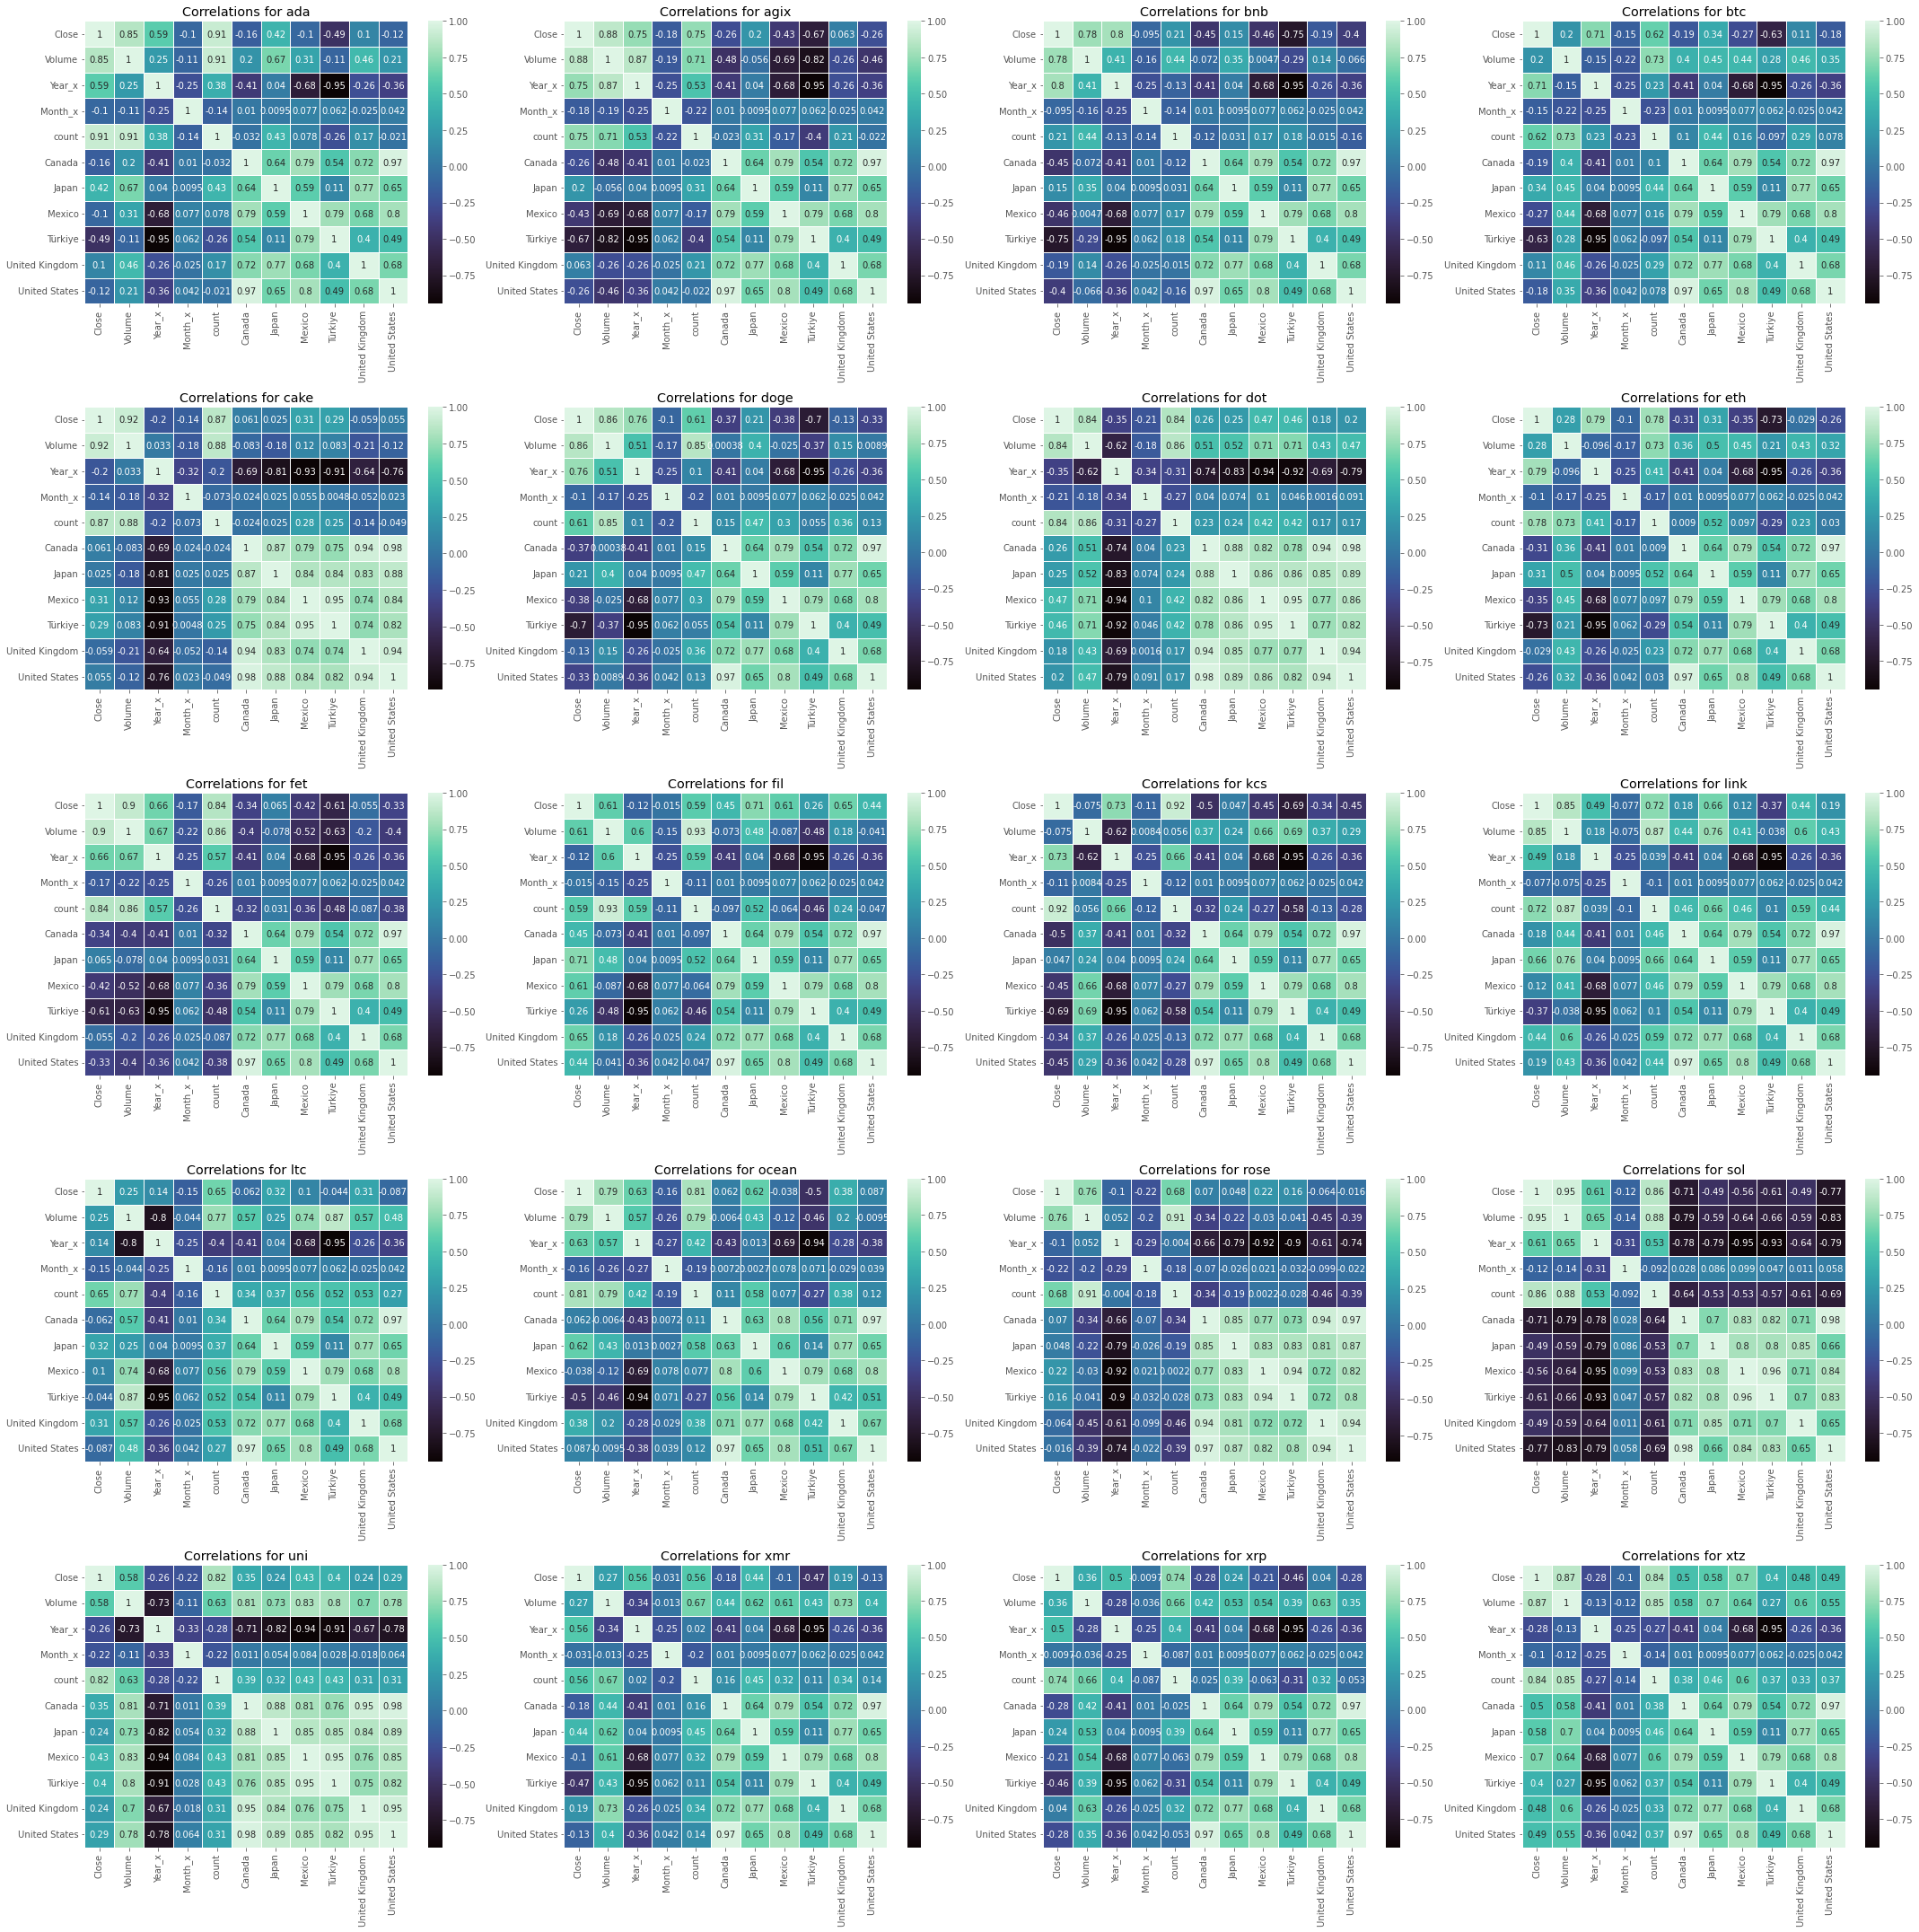

In [119]:

fig, axes = plt.subplots(5, 4, figsize=(30, 30))

columns =  ['Close', 'Volume', 'Year_x', 'Month_x', 'count', 'Canada',
       'Japan', 'Mexico', 'Türkiye', 'United Kingdom', 'United States']

for i, token in enumerate(tokens):
   trend_df = get_trend(token, trend_to_token_mapping)
   price_df = load_price_data(token, tokens, price_files)
   clean_price = clean_price_data(price_df)
   clean_trend = clean_trend_data(trend_df)
   price_trend_df = merging_df(clean_price, clean_trend)
   final_df = add_unemployment_rates(price_trend_df, crypto_countries)
   ax = axes[i // 4, i % 4]  # Get the appropriate subplot axes
   correlations(final_df[columns].apply(np.log), token, ax=ax)
 
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()
